In [1]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
%matplotlib inline

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

from IPython.display import display
import sympy; sympy.init_printing()
%matplotlib inline
import numpy
import matplotlib.pyplot as pyplot
from matplotlib import rcParams
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 16
rcParams['font.family'] = 'StixGeneral'

T = 0.25       # expiry time
r = 0.1        # no-risk interest rate
sigma = 0.4    # volatility of underlying asset
E = 10.        # exercise price
S_max = 4*E    # upper bound of price of the stock (4*E)

In [2]:
def LHS_matrix(M, alpha, beta, gamma):
    """generate and return the LHS coefficient matrix A.
    
    Arguments:
        M:       total number of spatials grids
        alpha:   array of coefficients on lower diagnoal
        beta:    array of coefficients on diagnoal
        gamma:   array of coefficients on upper diagnoal
    
    Returns:
        A:       LHS coefficient matrix
    """
    # diagonal
    d = numpy.diag(1+beta)
    # upper diagonal
    ud = numpy.diag(gamma[:-1], 1)
    # lower diagonal
    ld = numpy.diag(alpha[1:], -1)
    
    A = d +ud +ld
    return A

In [3]:
def RHS(C, alpha, beta, gamma, S_max, E):
    """generate and return the RHS vector b.
    
    Arguments:
        C:       array of the price of call option at previous time step
        alpha:   array of coefficients on lower diagnoal
        beta:    array of coefficients on diagnoal
        gamma:   array of coefficients on upper diagnoal
        S_max:   upper bound of stock price
        E:       exercise price
    
    Returns:
        b:       RHS vector
    """
    # diagonal of A_star
    d = numpy.diag(1-beta)
    # upper diagonal of A_star
    ud = numpy.diag(-gamma[:-1], 1)
    # lower diagonal of A_star
    ld = numpy.diag(-alpha[1:], -1)
    
    A_star = d + ud + ld
    b = numpy.dot(A_star,C[1:-1])
    # add BC for the right bound (the last element)
    b[-1] += -2*gamma[-1] * (S_max-E) 
    
    return b

In [4]:
def CrankNicolson(C, A, N, alpha, beta, gamma, S_max, E):
    """using Crank-Nicolson scheme to solve the Black-Scholes equation for the call option price.
    
    Arguments:
        C:       array of the price of call option
        A:       LHS coefficient matrix
        N:       total number of time steps       
        alpha:   array of coefficients on lower diagnoal
        beta:    array of coefficients on diagnoal
        gamma:   array of coefficients on upper diagnoal
        S_max:   upper bound of stock price
        E:       exercise price
    
    Returns:
        C:       array of the price of call option
    """
    for t in range(N):
        b = RHS(C, alpha, beta, gamma, S_max, E)
        # use numpy.linalg.solve
        C[1:-1] = solve(A,b)
    return C

In [5]:
from scipy.linalg import solve
N = 200        # number of time steps
M = 200        # number of space grids
dt = T/N       # time step
s = numpy.linspace(0, S_max, M+1)
# initial condition & boundary condition
C = s - E
C = numpy.clip(C, 0, S_max-E)

# calculating the coefficient arrays
index = numpy.arange(1,M)

alpha = dt/4 * (r*index - sigma**2*index**2)
beta = dt/2 * (r + sigma**2*index**2)
gamma = -dt/4 * (r*index + sigma**2*index**2)

In [6]:
A = LHS_matrix(M, alpha, beta, gamma)
C_imp = CrankNicolson(C, A, N, alpha, beta, gamma, S_max, E)
print ('the price of the call option should be around {}, \
if the price of stock is 20 dollar.'.format(C_imp[int(M/2)]))

the price of the call option should be around 10.246999510713625, if the price of stock is 20 dollar.


In [7]:
from scipy.stats import norm

C_exact = numpy.zeros(M+1)

d1 = (numpy.log1p(s/E) + (r+0.5*sigma**2)*T) / (sigma * numpy.sqrt(T))
d2 = d1 - (sigma * numpy.sqrt(T))
C_exact = s * norm.cdf(d1) - E*numpy.exp(-r*T) * norm.cdf(d2)
C_exact = numpy.clip(C_exact, 0, numpy.inf)

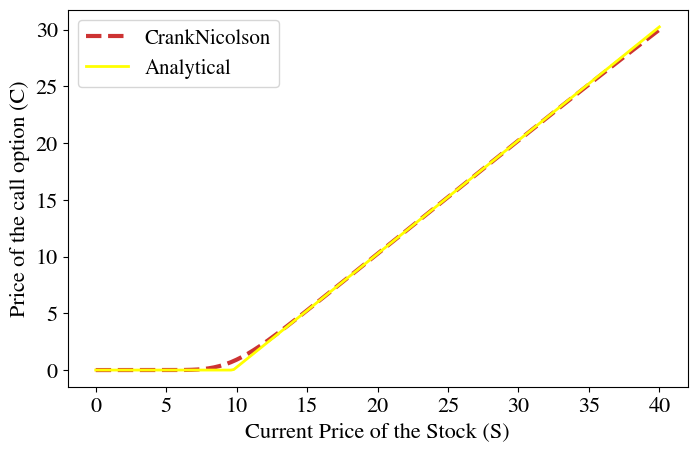

In [8]:
pyplot.figure(figsize=(8,5), dpi=100)
pyplot.plot(s, C_imp, color='#cd3333', ls='--', lw=3, label='CrankNicolson')
pyplot.plot(s, C_exact, color='#FFFF00', ls='-', lw=2, label='Analytical')
pyplot.xlabel('Current Price of the Stock (S)')
pyplot.ylabel('Price of the call option (C)')
pyplot.legend(loc='upper left',prop={'size':15});
pyplot.show()